In [15]:
!pip install pennylane
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [23]:
n_epochs = 20   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 10000    # Size of the train dataset
n_test = 1000     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
%cd "drive/MyDrive/Colab Notebooks/BTP"

/content/drive/MyDrive/Colab Notebooks/BTP


In [5]:
import pandas as pd

train = pd.read_csv("emnist-balanced-train.csv",delimiter = ',')
test = pd.read_csv("emnist-balanced-test.csv", delimiter = ',')
mapp = pd.read_csv("emnist-balanced-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train.shape, test.shape, mapp.shape))


Train: (112799, 785), Test: (18799, 785), Map: (47,)


In [6]:
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]
del train

test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]
del test


In [7]:
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(112799, 784) (112799,) (18799, 784) (18799,)


In [8]:
HEIGHT = 28
WIDTH = 28

def reshape(image):
    image = image.reshape([HEIGHT, WIDTH])
    return image


In [9]:
train_x = np.asarray(train_x)
train_x = np.apply_along_axis(reshape, 1, train_x)
print ("train_x:",train_x.shape)

test_x = np.asarray(test_x)
test_x = np.apply_along_axis(reshape, 1, test_x)
print ("test_x:",test_x.shape)


train_x: (112799, 28, 28)
test_x: (18799, 28, 28)


In [10]:
train_images = train_x[:n_train]
train_labels = train_y[:n_train]
test_images = test_x[:n_test]
test_labels = test_y[:n_test]

# Normalize pixel values within 0 and 1
train_images_temp = train_images / 255
test_images_temp = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images_temp[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images_temp[..., tf.newaxis], requires_grad=False)

In [11]:
train_images.shape

(10000, 28, 28, 1)

In [12]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]


In [13]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out


In [16]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):        
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):        
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images_set10k.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images_set10k.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images_set10k.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images_set10k.npy")


Quantum pre-processing of train images:

Quantum pre-processing of test images:


In [17]:
q_train_images.shape


(10000, 14, 14, 4)

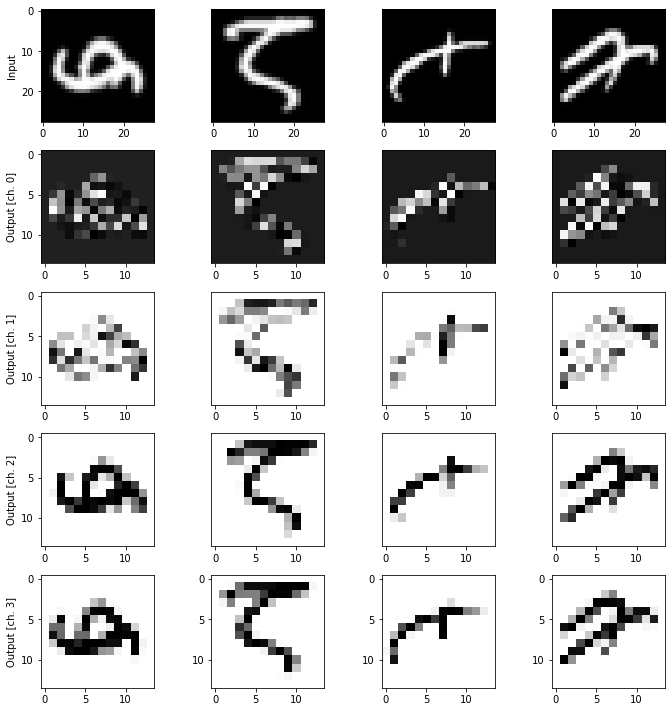

In [18]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [24]:
def MyModel1():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Conv2D(filters=128, kernel_size=(5,5), padding = 'same', activation='relu',\
                 input_shape=(14, 14, 4)), 
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)), 
        keras.layers.Conv2D(filters=64, kernel_size=(3,3) , padding = 'same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2,2)),                                                              
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(47, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [25]:
q_model = MyModel1()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=100,
    epochs=n_epochs,
    verbose=2,
)


Epoch 1/20
100/100 - 13s - loss: 2.5305 - accuracy: 0.3288 - val_loss: 1.2541 - val_accuracy: 0.6430
Epoch 2/20
100/100 - 13s - loss: 1.1638 - accuracy: 0.6532 - val_loss: 0.8657 - val_accuracy: 0.7560
Epoch 3/20
100/100 - 13s - loss: 0.8579 - accuracy: 0.7332 - val_loss: 0.7297 - val_accuracy: 0.7820
Epoch 4/20
100/100 - 13s - loss: 0.6999 - accuracy: 0.7754 - val_loss: 0.6326 - val_accuracy: 0.8100
Epoch 5/20
100/100 - 13s - loss: 0.6138 - accuracy: 0.8043 - val_loss: 0.6008 - val_accuracy: 0.8140
Epoch 6/20
100/100 - 13s - loss: 0.5551 - accuracy: 0.8155 - val_loss: 0.5614 - val_accuracy: 0.8240
Epoch 7/20
100/100 - 13s - loss: 0.5029 - accuracy: 0.8310 - val_loss: 0.5554 - val_accuracy: 0.8280
Epoch 8/20
100/100 - 13s - loss: 0.4608 - accuracy: 0.8404 - val_loss: 0.5449 - val_accuracy: 0.8270
Epoch 9/20
100/100 - 13s - loss: 0.4321 - accuracy: 0.8507 - val_loss: 0.5263 - val_accuracy: 0.8350
Epoch 10/20
100/100 - 13s - loss: 0.3888 - accuracy: 0.8645 - val_loss: 0.5092 - val_accura

In [26]:
def MyModel2():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Conv2D(filters=128, kernel_size=(5,5), padding = 'same', activation='relu',\
                 input_shape=(28, 28, 1)), 
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)), 
        keras.layers.Conv2D(filters=64, kernel_size=(3,3) , padding = 'same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2,2)),                                                              
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(47, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [27]:
c_model = MyModel2()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=100,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/20
100/100 - 36s - loss: 1.8909 - accuracy: 0.4829 - val_loss: 1.0125 - val_accuracy: 0.6990
Epoch 2/20
100/100 - 35s - loss: 0.8366 - accuracy: 0.7409 - val_loss: 0.7385 - val_accuracy: 0.8020
Epoch 3/20
100/100 - 35s - loss: 0.6420 - accuracy: 0.7952 - val_loss: 0.6761 - val_accuracy: 0.8010
Epoch 4/20
100/100 - 35s - loss: 0.5400 - accuracy: 0.8208 - val_loss: 0.6316 - val_accuracy: 0.8190
Epoch 5/20
100/100 - 35s - loss: 0.4712 - accuracy: 0.8412 - val_loss: 0.6331 - val_accuracy: 0.8060
Epoch 6/20
100/100 - 35s - loss: 0.4178 - accuracy: 0.8564 - val_loss: 0.6432 - val_accuracy: 0.8220
Epoch 7/20
100/100 - 35s - loss: 0.3748 - accuracy: 0.8725 - val_loss: 0.6493 - val_accuracy: 0.8180
Epoch 8/20
100/100 - 35s - loss: 0.3423 - accuracy: 0.8780 - val_loss: 0.6418 - val_accuracy: 0.8150
Epoch 9/20
100/100 - 35s - loss: 0.3066 - accuracy: 0.8899 - val_loss: 0.6226 - val_accuracy: 0.8340
Epoch 10/20
100/100 - 35s - loss: 0.2718 - accuracy: 0.9004 - val_loss: 0.6256 - val_accura

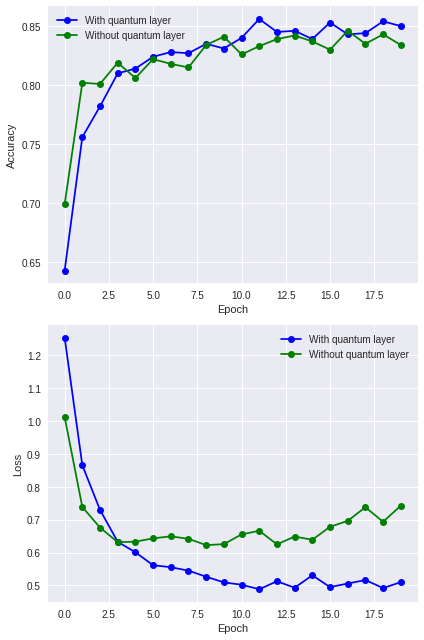

In [28]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

In [29]:
q_model.evaluate(q_test_images, test_labels)

32/32 [==============================] - 1s 13ms/step - loss: 0.5098 - accuracy: 0.8500


[0.50983065366745, 0.8500000238418579]

In [30]:
c_model.evaluate(test_images, test_labels)

32/32 [==============================] - 1s 31ms/step - loss: 0.7427 - accuracy: 0.8340


[0.7426559329032898, 0.8339999914169312]